In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import cv2

class pixel_estimator_with_weights(nn.Module):
    def __init__(self, Weights,device = "cuda:0"):
        ## Default: gpu mode
        super(pixel_estimator_with_weights, self).__init__()
        self.device = torch.device(device)
        self.w1 = torch.from_numpy(Weights[0].transpose(3,2,0,1)).to(self.device)
        self.b1 = torch.from_numpy(Weights[1]).to(self.device)
        self.w2 = torch.tensor(Weights[2].transpose(3,2,0,1)).to(self.device)
        self.b2 = torch.tensor(Weights[3]).to(self.device)
        self.w3 = torch.tensor(Weights[4].transpose(3,2,0,1)).to(self.device)
        self.b3 = torch.tensor(Weights[5]).to(self.device)
        self.w4 = torch.tensor(Weights[6]).reshape(4,4,8,1024).permute(3,2,0,1).to(self.device)
        self.b4 = torch.tensor(Weights[7]).to(self.device)
        self.w5 = torch.tensor(Weights[8]).reshape(1,1,1024,512).permute(3,2,0,1).to(self.device)
        self.b5 = torch.tensor(Weights[9]).to(self.device)
        self.w6 = torch.tensor(Weights[10]).reshape(1,1,512,10).permute(3,2,0,1).to(self.device)
        self.b6 = torch.tensor(Weights[11]).to(self.device)
        self.w7 = torch.tensor(Weights[12]).reshape(1,1,10,1).permute(3,2,0,1).to(self.device)
        self.b7 = torch.tensor(Weights[13]).to(self.device)

    def forward(self, x):
        x = F.relu(F.conv2d(x,self.w1,bias = self.b1,stride=1))
        x = F.relu(F.conv2d(x,self.w2,bias = self.b2,stride=1,dilation=8))
        x = F.relu(F.conv2d(x,self.w3,bias = self.b3,stride=1,dilation=32))
        x = F.leaky_relu(F.conv2d(x,self.w4,bias = self.b4,stride=1,dilation=128),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w5,bias = self.b5,stride=1),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w6,bias = self.b6,stride=1),0.1)
        x = F.conv2d(x,self.w7,bias = self.b7,stride=1)
        return x
    
    
def crop_patches(img, window= 1023, step = 512):
    patches = []
    H, W = img.shape
    for i in range(0, H-step, step):
        for j in range(0, W-step, step):
            patches.append(img[i:i+window, j:j+window])
    return np.stack(patches)


def gaf_func(img):
    assert img.max() <= 1.0
    assert img.shape == (2160, 3840)
    img = np.pad(img, ((200, 200), (128, 128)), 'reflect')
    H, W = img.shape
    
    patches = crop_patches(img)
    patches = torch.from_numpy(patches).float().unsqueeze(1).cuda()
        
    results = []
    with torch.no_grad():
        for i in range(patches.size()[0]):
            results.append(model(patches[i:i+1]))
    results = torch.stack(results)

    results = results.cpu().numpy()
    results = results.squeeze()
    
    k = 0
    sigma =1
    n_img = np.zeros((H-512, W-512))
    for i in range(0, H-512, 512):
        for j in range(0, W-512, 512):
            n_img[i:i+512, j:j+512] = results[k]
            k += 1
    
    n_img[n_img < 0] = 0
    return n_img

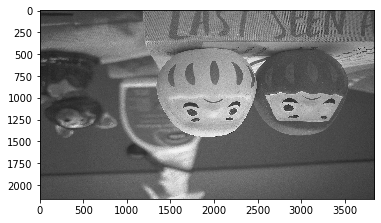

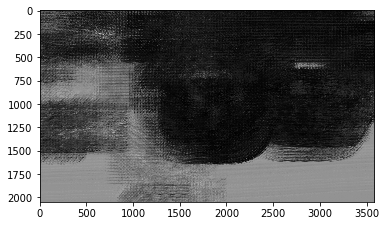

In [6]:
if __name__=='__main__':  
    model = torch.load('autofocus.pth')
    model.eval()
    
    image_name = '79854_s1000_02'
    
    img = cv2.imread('static_fs/{}.jpg'.format(image_name))
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)/255.0
    plt.imshow(gray_img, cmap='gray')
    plt.show()
    gaf = gaf_func(gray_img)
    
    
    np.save('static_fs/{}.npy'.format(image_name), gaf)
    
    plt.imshow(gaf, cmap='gray')
    plt.show()
    
    


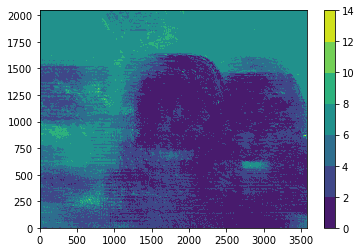

In [7]:
# X, Y = np.meshgrid(np.arange(3584), np.arange(2048))
plt.contourf(gaf)
plt.colorbar()
plt.show()

(array([1.578968e+06, 1.252999e+06, 6.779520e+05, 3.864910e+05,
        3.953960e+05, 4.434870e+05, 5.510920e+05, 5.942830e+05,
        5.246500e+05, 7.920750e+05, 1.397280e+05, 2.644000e+03,
        1.280000e+02, 4.500000e+01, 4.500000e+01, 1.800000e+01,
        1.100000e+01, 5.000000e+00, 9.000000e+00, 6.000000e+00]),
 array([ 0.        ,  0.75413599,  1.50827198,  2.26240797,  3.01654396,
         3.77067995,  4.52481594,  5.27895193,  6.03308792,  6.78722391,
         7.5413599 ,  8.29549589,  9.04963188,  9.80376787, 10.55790386,
        11.31203985, 12.06617584, 12.82031183, 13.57444782, 14.32858381,
        15.0827198 ]),
 <a list of 20 Patch objects>)

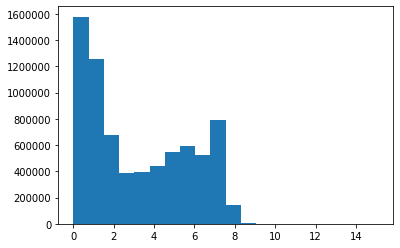

In [11]:
plt.hist(gaf.flatten(), bins=20)